# Steam Reviews Prediction

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text 
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

## Business Understanding
The objective of the notebook is to be able to predict whether or not a game will be recommended based off the review. By analyzing reviews, the model identifies key words and phrases that lead to positive or negative recommendations. This can help game developers and marketers understand what aspects of a game are most appreciated by users when creating a sequel or a game in a specific genre.

## Data Understanding

The data we will be looking at is a dataset acquired from Kaggle containing Steam reviews from 2017 and before.
> https://www.kaggle.com/datasets/andrewmvd/steam-reviews



The data will be downloaded and placed in the following path: `../data/dataset.csv`. It should be about a 2.6gb file when unzipped.

Now the data will be loaded as `df`

In [2]:
df = pd.read_csv('../data/dataset.csv')

Sneak peek of the data

In [3]:
df.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6417106 entries, 0 to 6417105
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   app_id        int64 
 1   app_name      object
 2   review_text   object
 3   review_score  int64 
 4   review_votes  int64 
dtypes: int64(3), object(2)
memory usage: 244.8+ MB


We can see that the data has over 6 million rows with the following structure:
1. `app_id`
   * Game ID
2. `app_name`
   * Game Name
3. `review_text`
   * Review Content
4. `review_score`
   * 1 for recommended, -1 for not recommended
5. `review_votes`
   * number of votes for how helpful the review was

The rows that will be relevant for training the model will be `review_score` and `review_votes` as we just need the content of the review and whether or not it was a positive review.


## Data Preparation

We are going to drop NA and duplicate rows.

In [5]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4483850 entries, 0 to 6417105
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   app_id        int64 
 1   app_name      object
 2   review_text   object
 3   review_score  int64 
 4   review_votes  int64 
dtypes: int64(3), object(2)
memory usage: 205.3+ MB


In [6]:
df.reset_index(drop=True, inplace=True)

In [7]:
df

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1
...,...,...,...,...,...
4483845,99910,Puzzle Pirates,I really ove this game but it needs somethings...,-1,0
4483846,99910,Puzzle Pirates,"Used to play Puzzel Pirates 'way back when', b...",-1,0
4483847,99910,Puzzle Pirates,"This game was aright, though a bit annoying. W...",-1,0
4483848,99910,Puzzle Pirates,"I had a nice review to recommend this game, bu...",-1,0


Grabbing just the `review_text` and `review_score` into its own dataframe because thats the only information we are concerned with when training this model.

In [8]:
data = df[['review_text', 'review_score']]

Sampling 5% of the data in order to cut down on the amount of data fed when training to reduce the model training time. To improve accuracy we can increase the sample size.

In [9]:
data_sample = data.sample(frac=0.05, random_state=42)
data_sample

,review_text,review_score
2431934,old school!,1
1250528,Game is very fun. It could use some tweeking a...,1
590126,A short emotionally provocative game that tran...,1
2110494,"Freedom fall is a short, simple, and very fun ...",1
2527583,I have played the witcher 2 and i can say that...,1
...,...,...
3350267,Larian managed to make the best RPG of the 201...,1
833185,You couldn’t pick up a guy at the gay bar Male...,1
3873486,"What is this game even? Honestly, no one knows...",1
4126649,"Seriously, buy this game. With all of the mod ...",1


In [12]:
data_sample.value_counts(['review_score'])

review_score
 1              183903
-1               40289
Name: count, dtype: int64

Running a train test split on the data with a test size of 0.2

In [13]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data_sample['review_text'], data_sample['review_score'], test_size=0.2, random_state=42)

Gathering a list of stop words in order to remove them during the TFIDF Vectorizer to cleanup the input of meaningless features.

In [18]:
stop_words = list(text.ENGLISH_STOP_WORDS)

Using the TFIDF Vectorizer in order to convert text data into numerical data to train the model. Looking at unigrams to trigrams.

In [15]:
tfidf = TfidfVectorizer(max_features=5000, stop_words=stop_words, ngram_range=(1,3))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

## Modeling

### Dummy Model

We are going to create a scores dictionary to keep track of all the scores of each model to compare later.

In [42]:
scores = []

We create a baseline model with the DummyClassifer to establish a baseline.

In [28]:
baseline_model = DummyClassifier(strategy='most_frequent')
baseline_model.fit(X_train_tfidf, y_train)
y_pred_baseline = baseline_model.predict(X_test_tfidf)
print("Baseline Model Performance:")
report = classification_report(y_test, y_pred_baseline)
print(report)

Baseline Model Performance:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00      7977
           1       0.82      1.00      0.90     36862

    accuracy                           0.82     44839
   macro avg       0.41      0.50      0.45     44839
weighted avg       0.68      0.82      0.74     44839



/opt/miniconda3/envs/mac_tf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/mac_tf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/mac_tf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [44]:
scores.append(['baseline_model', 'precision', precision_score(y_test, y_pred_baseline, average='macro')])
scores.append(['baseline_model', 'recall', recall_score(y_test, y_pred_baseline, average='macro')])
scores

/opt/miniconda3/envs/mac_tf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[['baseline_model', 'precision', 0.4110484176721158],
 ['baseline_model', 'recall', 0.5]]

As we can see the model is not great at predicting any negative recommendations and is extremely overfit.

### First Model
Next, we are going to create our first model using a Decision Tree with a couple of hyperparameters

In [20]:
param_grid = {
    'max_depth': [20],
    'min_samples_split': [10],
    'min_samples_leaf': [5]
}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, verbose=3)
grid_search.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=20, min_samples_leaf=5, min_samples_split=10;, score=0.843 total time=   7.5s
[CV 2/5] END max_depth=20, min_samples_leaf=5, min_samples_split=10;, score=0.842 total time=   7.3s
[CV 3/5] END max_depth=20, min_samples_leaf=5, min_samples_split=10;, score=0.846 total time=   7.6s
[CV 4/5] END max_depth=20, min_samples_leaf=5, min_samples_split=10;, score=0.843 total time=   7.6s
[CV 5/5] END max_depth=20, min_samples_leaf=5, min_samples_split=10;, score=0.841 total time=   7.7s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [20], 'min_samples_leaf': [5],
                         'min_samples_split': [10]},
             verbose=3)

Grabbing the best combination for the Decision Tree Model from the GridSearch

In [21]:
best_tree_model = grid_search.best_estimator_

And now that we have the best decision tree model we are going to evaluate the model's performance

In [46]:
y_pred_tree = best_tree_model.predict(X_test_tfidf)
print("Tuned Decision Tree Model Performance:")
print(classification_report(y_test, y_pred_tree))

Tuned Decision Tree Model Performance:
              precision    recall  f1-score   support

          -1       0.67      0.27      0.38      7977
           1       0.86      0.97      0.91     36862

    accuracy                           0.85     44839
   macro avg       0.76      0.62      0.65     44839
weighted avg       0.83      0.85      0.82     44839



In [47]:
scores.append(['decision_tree', 'precision', precision_score(y_test, y_pred_tree, average='macro')])
scores.append(['decision_tree', 'recall', recall_score(y_test, y_pred_tree, average='macro')])
scores

[['baseline_model', 'precision', 0.4110484176721158],
 ['baseline_model', 'recall', 0.5],
 ['decision_tree', 'precision', 0.7632120683261521],
 ['decision_tree', 'recall', 0.6183076212539242]]

As we can see the model here can actually predict negative recommendations however it still can be seen as overfit and way better at predicting positive recommendations than negative ones.

### Second Model
The next model I wanted to try is a Random Forest Classifier due to it's strength in handling imbalanced data better than simple Decision Trees and better insights on feature importance.

In [19]:
# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

Random Forest Model Performance:
              precision    recall  f1-score   support

          -1       0.77      0.41      0.54      7977
           1       0.88      0.97      0.93     36862

    accuracy                           0.87     44839
   macro avg       0.83      0.69      0.73     44839
weighted avg       0.86      0.87      0.86     44839



In [48]:
# Evaluate the model
y_pred_rf = rf_model.predict(X_test_tfidf)
print("Random Forest Model Performance:")
print(classification_report(y_test, y_pred_rf))


Random Forest Model Performance:
              precision    recall  f1-score   support

          -1       0.77      0.41      0.54      7977
           1       0.88      0.97      0.93     36862

    accuracy                           0.87     44839
   macro avg       0.83      0.69      0.73     44839
weighted avg       0.86      0.87      0.86     44839



In [49]:
scores.append(['random_forest', 'precision', precision_score(y_test, y_pred_rf, average='macro')])
scores.append(['random_forest', 'recall', recall_score(y_test, y_pred_rf, average='macro')])
scores

[['baseline_model', 'precision', 0.4110484176721158],
 ['baseline_model', 'recall', 0.5],
 ['decision_tree', 'precision', 0.7632120683261521],
 ['decision_tree', 'recall', 0.6183076212539242],
 ['random_forest', 'precision', 0.828494685755017],
 ['random_forest', 'recall', 0.6933605324820007]]

## Evaluation

Now we are going to compare the scores of each of the models and determine which one was the most successful and if it successful enough to be deployed.

In [50]:
scores_df = pd.DataFrame(scores, columns=['Model', 'Metric', 'Score'])
scores_df

,Model,Metric,Score
0,baseline_model,precision,0.411048
1,baseline_model,recall,0.500000
2,decision_tree,precision,0.763212
3,decision_tree,recall,0.618308
4,random_forest,precision,0.828495
5,random_forest,recall,0.693361


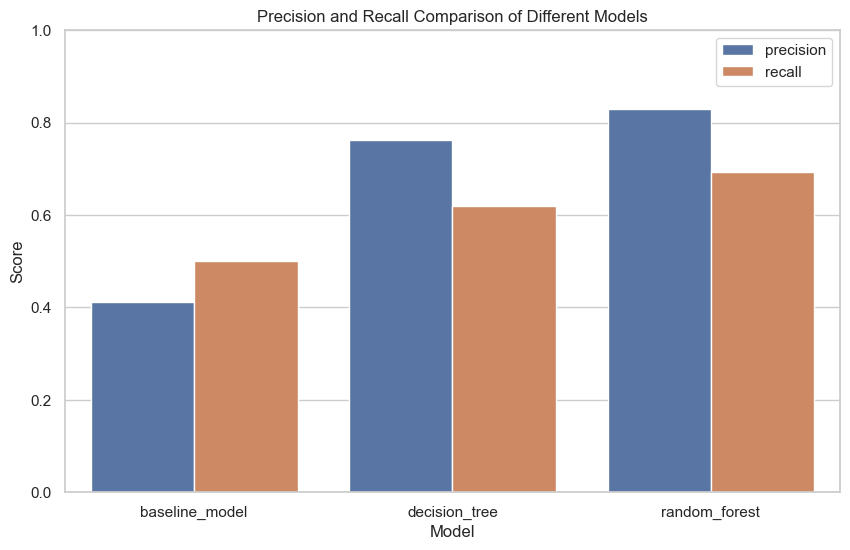

In [53]:
# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=scores_df)

# Add titles and labels
plt.title('Precision and Recall Comparison of Different Models')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1)

# Show the plot
plt.legend(loc='upper right')
plt.show()

After training the model and retrieving the classification report, we can see that the Random Forest Classifer is a clear improvement to the previous two models due to its near 10% increase in precision on negative recommendations and near 20% increase on the recall while still maintaining very high values for the positive recommendations.

Because the best model was concluded as the random forest we are going to look at the model's feature importances to deduce which words or phrases made the most impact in determining whether or not a review is positive.

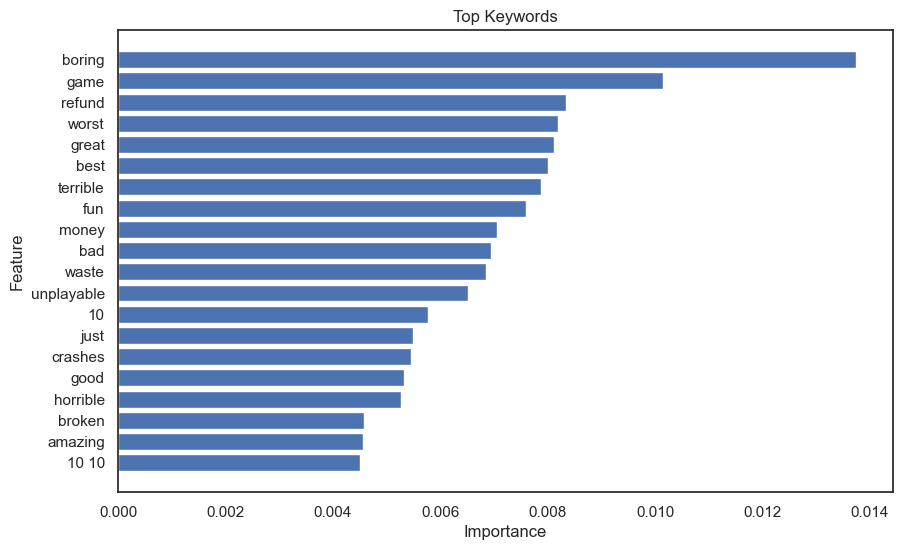

In [56]:
# Feature importance
feature_names = tfidf.get_feature_names_out()
importance = rf_model.feature_importances_
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importance})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

# Plot top keywords
top_features = 20
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:top_features], feature_importance['importance'][:top_features])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top Keywords')
plt.gca().invert_yaxis()
plt.show()

We can see that not many phrases were recognized as important features but it's likely due to the small sample of data that was fed through the model. Additionally, we can see arguable stop words also contributing to the importance such as 'just'. This is something to look out for in the future as the model should still be further trained with hyperparameters in effect and more training data being sent through.

Using the random forest model we can feed in a 'custom' review and have the vectorizer transform it for us and sent to the model to predict whether or not the review is positive or not.

In [53]:
# Example new review
new_review = ["waste i hated it"]

# Transform the new review
new_review_tfidf = tfidf.transform(new_review)

# Make prediction using the best model (assuming best_model is already defined and trained)
prediction = rf_model.predict(new_review_tfidf)
print(prediction)

# Interpret the prediction
if prediction[0] == 1:
    print("The model predicts: Recommended")
else:
    print("The model predicts: Not Recommended")

[-1]
The model predicts: Not Recommended


I want to emphasize that the beauty in this project is not necessarily the model predicting yay or nay but in the features that can be identified as important for either direction. Game developers can look at this newly organized data when pursuing the creation of a new game to find what is something that is sought after in games of a specific name or genre.

Although the model was mostly successful in predicting yay or nay, we want to further reduce the false positives that are returned by the model. However, it is worth noting that the current behavior is preferred to underfitting due to the users of this model wanting to further focus on what is positive and good for a game rather than the negative because by doing what is desired you avoid what is undesired.

### Next Steps:

The model can always be further improved but the real next steps to be accomplished before deployment is further honing in on the features that contribute to positive reviews and categorizing them for specific game franchises or genres to a centralized location that can quickly be parsed for the information a game developer or studio is looking for. In order to improve the model's accuracy or increase the list of important features, we can increase the sample size that was fed into the model (for time purposes) and enforce a more equal weighted distributions between the samples that are picked between positive and negative sentiments.

**Steps**: 
1. Improve the model
2. Further filter important features
3. Create associations between the important features and the sentiment
4. Store categorized features in a database that is accessible through a webapp.
5. Profit